<h1>1- Define The Ajax Based Calling To Youtube</h1>

In [6]:
from __future__ import print_function

import io
import json
import os
import sys
import time
from matplotlib import pyplot as plt 
import numpy as np
import argparse
import lxml.html
import requests
from lxml.cssselect import CSSSelector

YOUTUBE_VIDEO_URL = 'https://www.youtube.com/watch?v={youtube_id}'
YOUTUBE_COMMENTS_AJAX_URL_OLD = 'https://www.youtube.com/comment_ajax'
YOUTUBE_COMMENTS_AJAX_URL_NEW = 'https://www.youtube.com/comment_service_ajax'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'


def find_value(html, key, num_chars=2, separator='"'):
    pos_begin = html.find(key) + len(key) + num_chars
    pos_end = html.find(separator, pos_begin)
    return html[pos_begin: pos_end]


def ajax_request(session, url, params=None, data=None, headers=None, retries=5, sleep=20):
    for _ in range(retries):
        response = session.post(url, params=params, data=data, headers=headers)
        if response.status_code == 200:
            return response.json()
        if response.status_code in [403, 413]:
            return {}
        else:
            time.sleep(sleep)


def download_comments(youtube_id, sleep=.1):
    if r'\"isLiveContent\":true' in requests.get(YOUTUBE_VIDEO_URL.format(youtube_id=youtube_id)).text:
        print('Live stream detected! Not all comments may be downloaded.')
        return download_comments_new_api(youtube_id, sleep)
    return download_comments_old_api(youtube_id, sleep)


def download_comments_new_api(youtube_id, sleep=1):
    # Use the new youtube API to download some comments
    session = requests.Session()
    session.headers['User-Agent'] = USER_AGENT

    response = session.get(YOUTUBE_VIDEO_URL.format(youtube_id=youtube_id))
    html = response.text
    session_token = find_value(html, 'XSRF_TOKEN', 3)

    data = json.loads(find_value(html, 'window["ytInitialData"] = ', 0, '\n').rstrip(';'))
    for renderer in search_dict(data, 'itemSectionRenderer'):
        ncd = next(search_dict(renderer, 'nextContinuationData'), None)
        if ncd:
            break
    continuations = [(ncd['continuation'], ncd['clickTrackingParams'])]

    while continuations:
        continuation, itct = continuations.pop()
        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL_NEW,
                                params={'action_get_comments': 1,
                                        'pbj': 1,
                                        'ctoken': continuation,
                                        'continuation': continuation,
                                        'itct': itct},
                                data={'session_token': session_token},
                                headers={'X-YouTube-Client-Name': '1',
                                         'X-YouTube-Client-Version': '2.20200207.03.01'})

        if not response:
            break
        if list(search_dict(response, 'externalErrorMessage')):
            raise RuntimeError('Error returned from server: ' + next(search_dict(response, 'externalErrorMessage')))

        # Ordering matters. The newest continuations should go first.
        continuations = [(ncd['continuation'], ncd['clickTrackingParams'])
                         for ncd in search_dict(response, 'nextContinuationData')] + continuations

        for comment in search_dict(response, 'commentRenderer'):
            yield {'cid': comment['commentId'],
                   'text': ''.join([c['text'] for c in comment['contentText']['runs']]),
                   'time': comment['publishedTimeText']['runs'][0]['text'],
                   'author': comment.get('authorText', {}).get('simpleText', ''),
                   'channel': comment['authorEndpoint']['browseEndpoint']['browseId'],
                   'votes': comment.get('voteCount', {}).get('simpleText', '0'),
                   'photo': comment['authorThumbnail']['thumbnails'][-1]['url'],
                   'heart': next(search_dict(comment, 'isHearted'), False)}

        time.sleep(sleep)


def search_dict(partial, key):
    if isinstance(partial, dict):
        for k, v in partial.items():
            if k == key:
                yield v
            else:
                for o in search_dict(v, key):
                    yield o
    elif isinstance(partial, list):
        for i in partial:
            for o in search_dict(i, key):
                yield o


def download_comments_old_api(youtube_id, sleep=1):
    # Use the old youtube API to download all comments (does not work for live streams)
    session = requests.Session()
    session.headers['User-Agent'] = USER_AGENT

    # Get Youtube page with initial comments
    response = session.get(YOUTUBE_VIDEO_URL.format(youtube_id=youtube_id))
    html = response.text

    reply_cids = extract_reply_cids(html)

    ret_cids = []
    for comment in extract_comments(html):
        ret_cids.append(comment['cid'])
        yield comment

    page_token = find_value(html, 'data-token')
    session_token = find_value(html, 'XSRF_TOKEN', 3)

    first_iteration = True

    # Get remaining comments (the same as pressing the 'Show more' button)
    while page_token:
        data = {'video_id': youtube_id,
                'session_token': session_token}

        params = {'action_load_comments': 1,
                  'order_by_time': True,
                  'filter': youtube_id}

        if first_iteration:
            params['order_menu'] = True
        else:
            data['page_token'] = page_token

        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL_OLD, params, data)
        if not response:
            break

        page_token, html = response.get('page_token', None), response['html_content']

        reply_cids += extract_reply_cids(html)
        for comment in extract_comments(html):
            if comment['cid'] not in ret_cids:
                ret_cids.append(comment['cid'])
                yield comment

        first_iteration = False
        time.sleep(sleep)

    # Get replies (the same as pressing the 'View all X replies' link)
    for cid in reply_cids:
        data = {'comment_id': cid,
                'video_id': youtube_id,
                'can_reply': 1,
                'session_token': session_token}

        params = {'action_load_replies': 1,
                  'order_by_time': True,
                  'filter': youtube_id,
                  'tab': 'inbox'}

        response = ajax_request(session, YOUTUBE_COMMENTS_AJAX_URL_OLD, params, data)
        if not response:
            break

        html = response['html_content']

        for comment in extract_comments(html):
            if comment['cid'] not in ret_cids:
                ret_cids.append(comment['cid'])
                yield comment
        time.sleep(sleep)


def extract_comments(html):
    tree = lxml.html.fromstring(html)
    item_sel = CSSSelector('.comment-item')
    text_sel = CSSSelector('.comment-text-content')
    time_sel = CSSSelector('.time')
    author_sel = CSSSelector('.user-name')
    vote_sel = CSSSelector('.like-count.off')
    photo_sel = CSSSelector('.user-photo')
    heart_sel = CSSSelector('.creator-heart-background-hearted')

    for item in item_sel(tree):
        yield {'cid': item.get('data-cid'),
               'text': text_sel(item)[0].text_content(),
               'time': time_sel(item)[0].text_content().strip(),
               'author': author_sel(item)[0].text_content(),
               'channel': item[0].get('href').replace('/channel/','').strip(),
               'votes': vote_sel(item)[0].text_content() if len(vote_sel(item)) > 0 else 0,
               'photo': photo_sel(item)[0].get('src'),
               'heart': bool(heart_sel(item))}


def extract_reply_cids(html):
    tree = lxml.html.fromstring(html)
    sel = CSSSelector('.comment-replies-header > .load-comments')
    return [i.get('data-cid') for i in sel(tree)]

<h1>2- Call the Functions For Data Scraping From Youtube</h1>
<b> Enter the Video ID in 2nd Line for Comment Scraping</b>

In [86]:
try:
    youtube_id = 'io6wi8DVZ3o' #    3gJngOCyrZg , https://www.youtube.com/watch?v=io6wi8DVZ3o   [donald trump]
    output = 'output.json'
    limit = 10000 # we can change limit 

    if not youtube_id or not output:
        parser.print_usage()
        raise ValueError('you need to specify a Youtube ID and an output filename')

    if os.sep in output:
        outdir = os.path.dirname(output)
        if not os.path.exists(outdir):
            os.makedirs(outdir)

    print('Downloading Youtube comments for video:', youtube_id)
    count = 0
    with io.open(output, 'w', encoding='utf8') as fp:
        sys.stdout.write('Downloaded %d comment(s)\r' % count)
        sys.stdout.flush()
        start_time = time.time()
        for comment in download_comments(youtube_id):
            comment_json = json.dumps(comment, ensure_ascii=False)
            print(comment_json.decode('utf-8') if isinstance(comment_json, bytes) else comment_json, file=fp)
            count += 1
            sys.stdout.write('Downloaded %d comment(s)\r' % count)
            sys.stdout.flush()
            if limit and count >= limit:
                break
    print('\n[{:.2f} seconds] Done!'.format(time.time() - start_time))

except Exception as e:
    print('Error:', str(e))
    sys.exit(1)

Downloaded 10000 comment(s)
[381.52 seconds] Done!


<h1>3- Load the JSON File in which Comments are Scraped</h1>

In [147]:
complete_data = []
for line in open(r'C:\Users\Ali\Desktop\dawn sentiment analysis\output.json', 'r', encoding="utf8"):
        complete_data.append(json.loads(line))

In [148]:
comments = []
for item in complete_data:
    comments.append(item['text'])

<h1>4- Convert List to Dataframe </h1>

In [149]:
import pandas as pd
df=pd.DataFrame(comments)
df['Comments']=df

In [150]:
df['Comments']

0       The Roast of Alec Baldwin premieres September ...
1                           why y’all be roasting me for?
2       Man yall cut out the harshest joke that Anthon...
3       @Dan Tell that to the thousands of dead innoce...
4       how the f..k can someone roast the President o...
                              ...                        
9995    I will never follow these assholes roasting Trump
9996                                        This was 2011
9997                          Trump's existence is a joke
9998            Why does trump look like an old socks huh
9999    "You've said you wanna be president, why not? ...
Name: Comments, Length: 10000, dtype: object

<h1>5- Applying Natural Language Processing</h1>

In [151]:
import nltk 
import json

<b>Characters Count</b>

In [152]:
num_char = []
for row in df['Comments']:
    num_char.append(len(row))


<b>Plotting the Character Count </b>

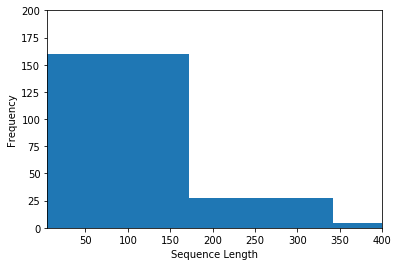

In [93]:
import matplotlib.pyplot as plt
plt.hist(numWords, 28)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([5,400 , 0, 200])
plt.show()

<h1>6- Sentiment Analysis </h1>

In [94]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [95]:
df=df.drop([0], axis=1)
df['scores'] = df['Comments'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Comments,scores
0,The Roast of Alec Baldwin premieres September ...,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp..."
1,why y’all be roasting me for?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Man yall cut out the harshest joke that Anthon...,"{'neg': 0.293, 'neu': 0.605, 'pos': 0.102, 'co..."
3,@Dan Tell that to the thousands of dead innoce...,"{'neg': 0.278, 'neu': 0.633, 'pos': 0.089, 'co..."
4,how the f..k can someone roast the President o...,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp..."


In [96]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

,Comments,scores,compound
0,The Roast of Alec Baldwin premieres September ...,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.3612
1,why y’all be roasting me for?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,Man yall cut out the harshest joke that Anthon...,"{'neg': 0.293, 'neu': 0.605, 'pos': 0.102, 'co...",-0.6239
3,@Dan Tell that to the thousands of dead innoce...,"{'neg': 0.278, 'neu': 0.633, 'pos': 0.089, 'co...",-0.6705
4,how the f..k can someone roast the President o...,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",0.4753


In [97]:
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
df.head()

,Comments,scores,compound,comp_score
0,The Roast of Alec Baldwin premieres September ...,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.3612,pos
1,why y’all be roasting me for?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
2,Man yall cut out the harshest joke that Anthon...,"{'neg': 0.293, 'neu': 0.605, 'pos': 0.102, 'co...",-0.6239,neg
3,@Dan Tell that to the thousands of dead innoce...,"{'neg': 0.278, 'neu': 0.633, 'pos': 0.089, 'co...",-0.6705,neg
4,how the f..k can someone roast the President o...,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",0.4753,pos


In [98]:
df['scores'][0]

{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'compound': 0.3612}

<h1>7- Visualize Sentiment Analysis </h1>

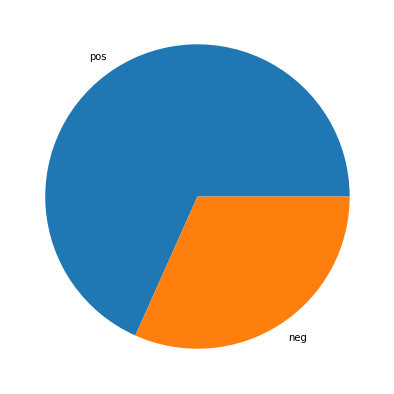

In [99]:
data = df['comp_score'].value_counts() 
labels=data.index
fig = plt.figure(figsize =(10, 7)) 
plt.pie(data, labels = labels) 

# show plot 
plt.show()

<h1>8- Plotting the WordCloud</h1>

In [100]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [101]:
text=df['Comments'].astype(str)
# Clean text
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))


In [102]:
text = re.sub(r'==.*?==+', "", str(text))
text = text.replace('\n', "")
print(text)

0       The Roast of Alec Baldwin premieres September ...1                           why y’all be roasting me for?2       Man yall cut out the harshest joke that Anthon...3       @Dan Tell that to the thousands of dead innoce...4       how the f..k can someone roast the President o...                              ...                        9995    I will never follow these assholes roasting Trump9996                                        This was 20119997                          Trump's existence is a joke9998            Why does trump look like an old socks huh9999    "You've said you wanna be president, why not? ...Name: Comments, Length: 10000, dtype: object


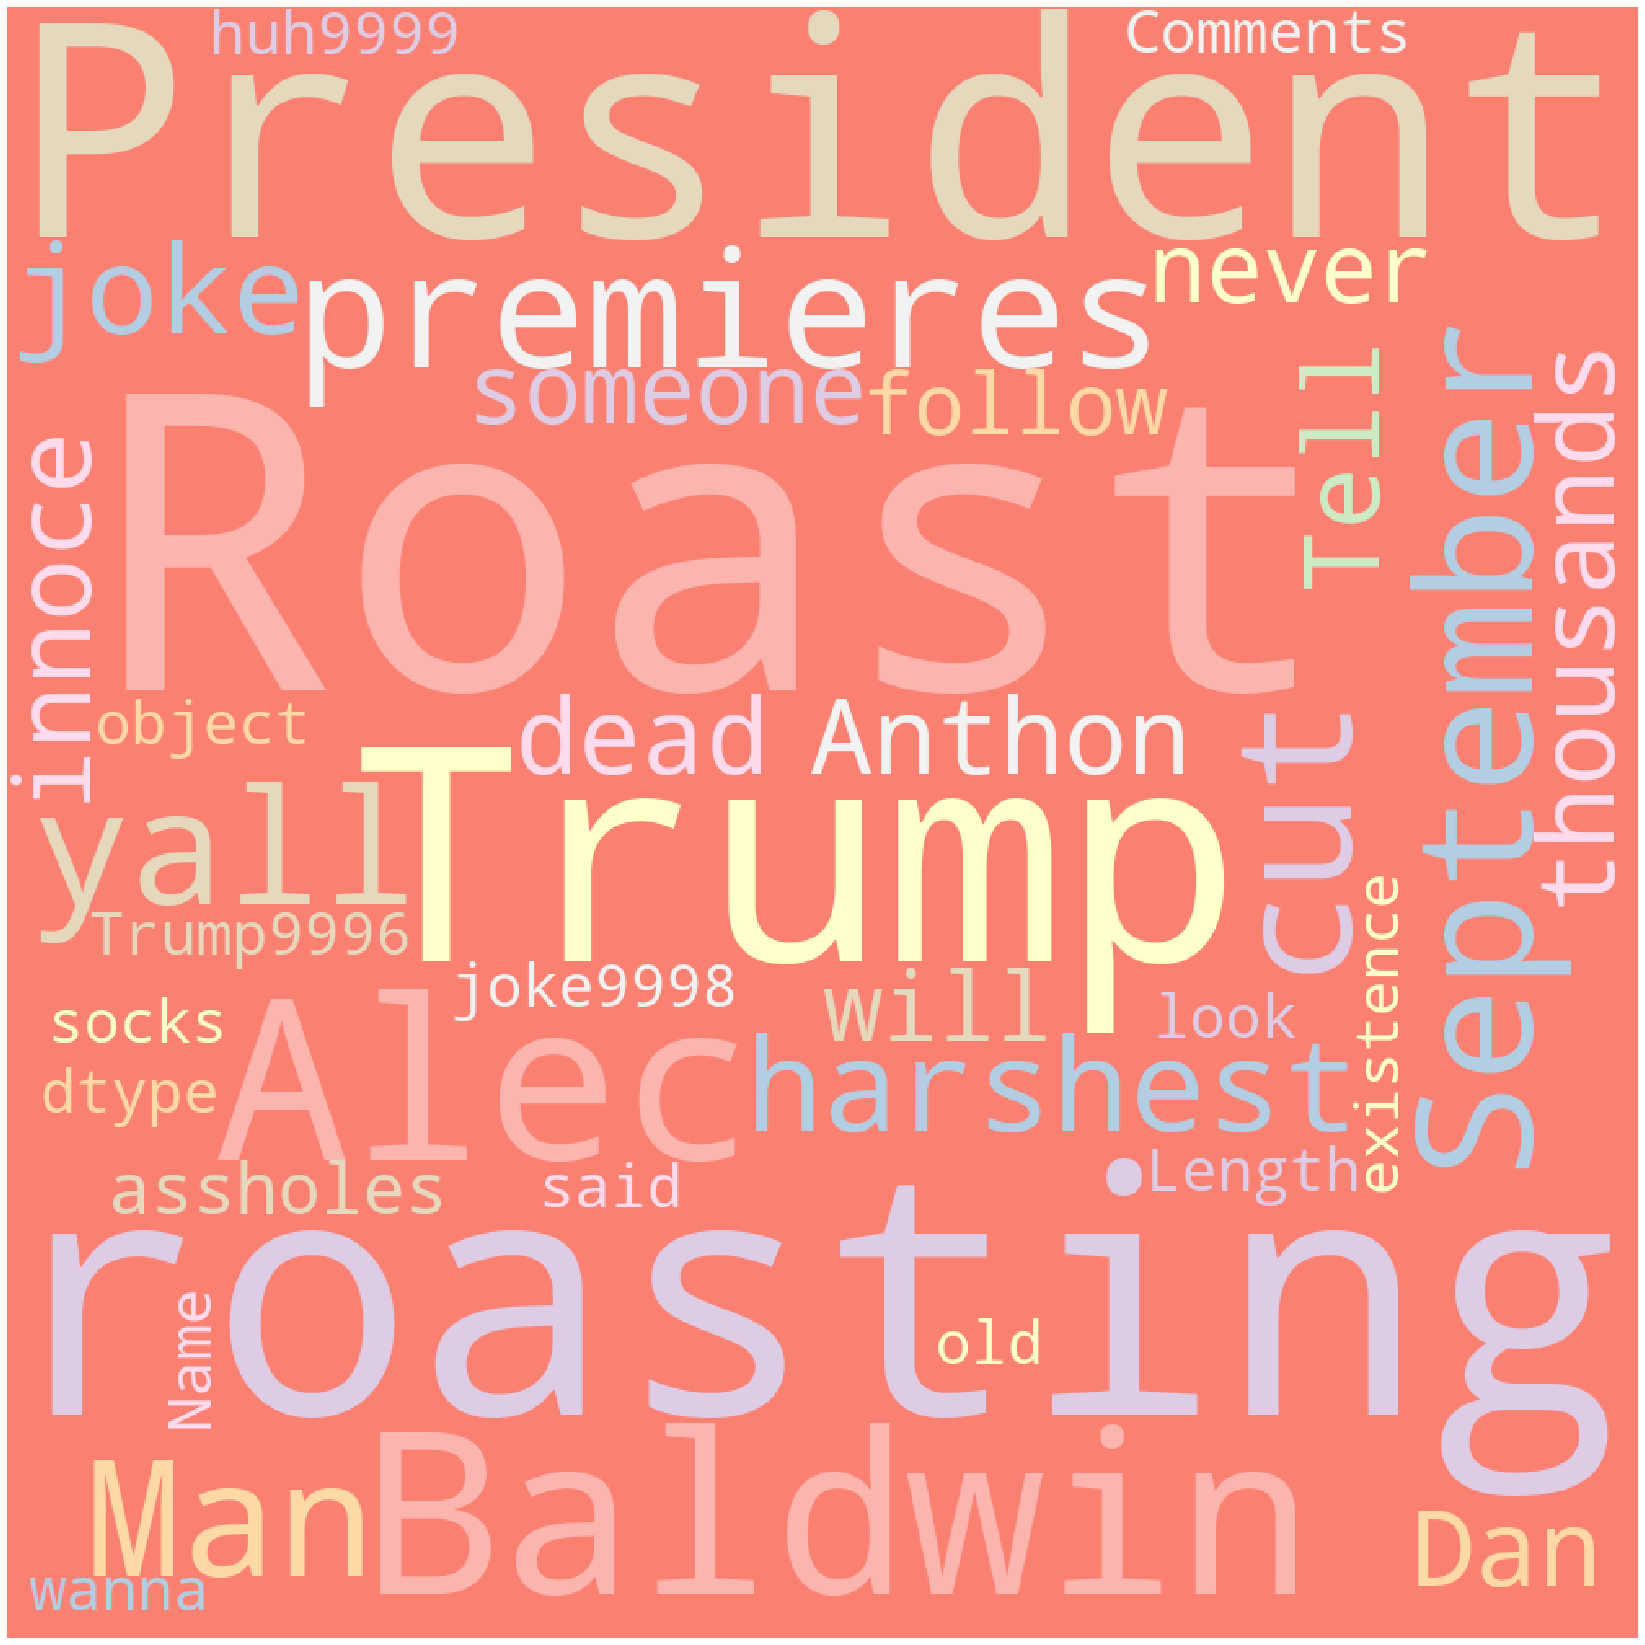

In [103]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 1000, height = 1000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

<h1>9- Deep Learning[LSTM] Classification Algorithm on Saved Dataset</h1>

In [118]:
#LSTM Modeling
#Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
#Limit the data set to the top 4,0000 words.
#Set the max number of words in each complaint at 250.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords

In [120]:
# The maximum number of words to be used. (most frequent)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
MAX_NB_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 101
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Comments'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13731 unique tokens.


In [125]:
X = tokenizer.texts_to_sequences(df['Comments'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [123]:
#Converting categorical labels to numbers.

Y = pd.get_dummies(df['comp_score']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 2)


In [126]:
#Train test split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.40, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6000, 250) (6000, 2)
(4000, 250) (4000, 2)


In [128]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.25)#,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]

Train on 4500 samples, validate on 1500 samples
Epoch 1/10
4500/4500 [==============================] - 94s 21ms/sample - loss: 0.5939 - accuracy: 0.6811 - val_loss: 0.5600 - val_accuracy: 0.7040
Epoch 2/10
4500/4500 [==============================] - 74s 16ms/sample - loss: 0.4532 - accuracy: 0.7929 - val_loss: 0.4688 - val_accuracy: 0.7973
Epoch 3/10
4500/4500 [==============================] - 74s 17ms/sample - loss: 0.2623 - accuracy: 0.9013 - val_loss: 0.4757 - val_accuracy: 0.7887
Epoch 4/10
4500/4500 [==============================] - 74s 16ms/sample - loss: 0.1643 - accuracy: 0.9396 - val_loss: 0.5151 - val_accuracy: 0.8007
Epoch 5/10
4500/4500 [==============================] - 75s 17ms/sample - loss: 0.1059 - accuracy: 0.9633 - val_loss: 0.5534 - val_accuracy: 0.8040
Epoch 6/10
4500/4500 [==============================] - 74s 16ms/sample - loss: 0.0682 - accuracy: 0.9778 - val_loss: 0.6946 - val_accuracy: 0.7940
Epoch 7/10
4500/4500 [==============================] - 74s 16ms

In [130]:
accr_model = model.evaluate(X_test,Y_test)
#save keras model
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_model[0],accr_model[1]))

4000/4000 [==============================] - 13s 3ms/sample - loss: 1.0368 - accuracy: 0.7810
Test set
  Loss: 1.037
  Accuracy: 0.781


In [131]:
#predict using the saved model
y_pred=model.predict_classes(X_test)#X_test in place of X_train

In [132]:
#confusion Matrix to LSTM-Classifier

#y_pred=model.predict_classes(X_test) # predict_classes used the round variable values instead of points
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import numpy as np
tests=np.argmax(Y_test, axis=1) # write the Y_test in place of Y_train convert the decimal points to rounded 
# we provide the confusion matrix a rounded value otherwise a classification matrix problem arieses
cm=confusion_matrix(y_pred, tests)
print(cm)

pd_cm=pd.DataFrame(cm)

print('Accuracy Score :',accuracy_score(tests, y_pred)) 
print('Report : ') 
print(classification_report(tests, y_pred))  
print(pd_cm)

[[ 801  421]
 [ 455 2323]]
Accuracy Score : 0.781
Report : 
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1256
           1       0.84      0.85      0.84      2744

    accuracy                           0.78      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.78      0.78      0.78      4000

     0     1
0  801   421
1  455  2323


<h1> 10- Confusion Matrix Using Seaborn</h1>

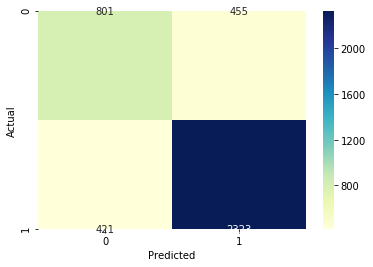

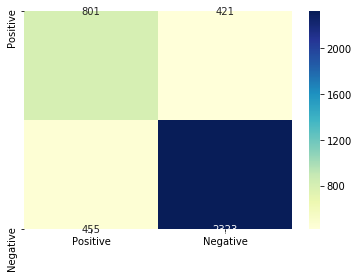

In [145]:
#confusion matrix by seaborn
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    tests,
        'y_Predicted': y_pred,
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted', 'Lables'])
df.head()
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'])
confusion_matrix
sn.heatmap(confusion_matrix, annot=True,fmt="d", cmap="YlGnBu")
plt.savefig('save_as_a_png.png')
plt.show()

pd_cm.columns=["Positive","Negative"]
pd_cm.index=["Positive","Negative"]
sn.heatmap(pd_cm, annot=True,fmt="d", cmap="YlGnBu")
plt.savefig("cm.png" ,dpi=300, bbox_inches='tight')